# 심층 합성곱 생성적 적대 신경망 (Deep Convolutional Generative Adversarial Networks, DCGAN)

In [1]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio
!pip install -q tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 3.2 MB/s eta 0:00:00


In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time

from IPython import display

### 데이터세트 로드 및 준비하기

생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용할것입니다. 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다.

In [3]:
# mnist dataset load
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
#(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images.shape

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [4]:
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

train_images.shape, train_images.max(), train_images.min()

((60000, 28, 28, 1), 1.0, -1.0)

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

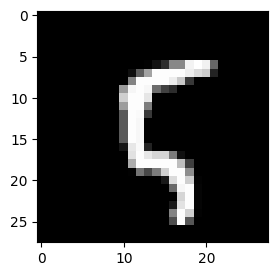

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(train_images[100], cmap = 'gray')

## 모델 만들기

### 생성자

생성자는 시드값(임의의 노이즈)에서 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose`(업샘플링) 레이어를 이용합니다. 처음 `Dense` 레이어는 해당 시드값을 입력값으로 받습니다. 다음으로 원하는 크기인 28x28x1의 이미지에 도달할 때까지 업샘플링을 여러 번 수행합니다. tanh 함수를 사용하는 출력 레이어를 제외한 각 레이어에서 `tf.keras.layers.LeakyReLU` 활성화가 사용됩니다.

In [15]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, Flatten

import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose

def make_generator_model():
    model = tf.keras.Sequential()

    # 입력 차원: 100, 출력 차원: 7*7*256
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # 1차원 출력을 3차원으로 변환 (7x7x256)
    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)     # 출력 형태 확인

    # 역 컨볼루션 레이어 추가 (128 필터, 5x5 커널)
    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)    # 출력 형태 확인
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # 역 컨볼루션 레이어 추가 (64 필터, 5x5 커널)
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    # 출력 형태 확인
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # 최종 역 컨볼루션 레이어 (1 필터, 5x5 커널, 'tanh' 활성화)
    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)      # 출력 형태 확인

    return model

generator = make_generator_model()

In [12]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)        

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해봅시다.

(1, 28, 28, 1)


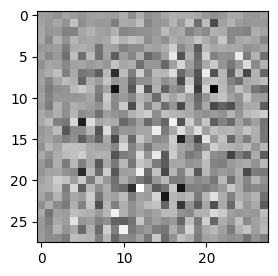

In [14]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.figure(figsize=(3, 3))
plt.imshow(generated_image[0], cmap='gray')

### 감별자

감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 64 필터, 5x5 커널, 2x2 스트라이드, 입력 형태 [28, 28, 1]
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # 128 필터, 5x5 커널, 2x2 스트라이드
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())      # 2D 출력을 1D로 변환
    model.add(Dense(1))     # 분류를 위한 출력 생성

    return model

discriminator = make_discriminator_model()

In [19]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [21]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00112598]], shape=(1, 1), dtype=float32)


## 손실과 옵티마이저 정의하기

두 모델의 손실 함수와 옵티마이저를 정의합니다.


In [22]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수

이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [24]:
def discriminator_loss(real_output, fake_output):
    # 진짜 이미지에 대한 손실 계산
    # 진짜 이미지 출력(real_output)이 1(진짜)로 인식되도록 하는 손실
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # 가짜 이미지에 대한 손실 계산
    # 가짜 이미지 출력(fake_output)이 0(가짜)으로 인식되도록 하는 손실
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # 총 손실은 진짜 이미지 손실과 가짜 이미지 손실의 합
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수

생성자의 손실은 판별자를 얼마나 잘 속일 수 있었는지를 수치화합니다. 직관적으로, 생성자가 잘 작동하면 판별자는 가짜 이미지를 실제(또는 1)로 분류합니다. 여기에서 생성된 이미지에 대한 판별자의 판단을 1의 배열과 비교합니다.

In [25]:
def generator_loss(fake_output):
    # 가짜 이미지에 대한 손실 계산
    # 생성자가 생성한 가짜 이미지(fake_output)가 진짜(1)로 인식되도록 하는 손실
    return cross_entropy(tf.ones_like(fake_output), fake_output)

판별자와 생성자 옵티마이저는 두 네트워크를 별도로 훈련하기 때문에 서로 다릅니다.

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장

이 노트북은 오랫동안 진행되는 훈련이 중단된 경우 유용한 모델의 저장 및 복구 방법을 보여줍니다.

In [28]:
# 체크포인트를 저장할 디렉토리 설정
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 생성자와 판별자의 옵티마이저 및 모델 상태를 저장합니다
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

## 훈련 루프 정의하기


In [29]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용합니다.
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

생성자가 입력으로 임의의 시드를 받으면 훈련 루프가 시작됩니다. 해당 시드는 이미지를 생성하는 데 사용됩니다. 감별자를 사용하여 (훈련 세트에서 가져온) 진짜 이미지와 (생성자를 통해 생성된) 가짜 이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트를 사용해 생성자와 감별자를 업데이트합니다.

In [30]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):

    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # noise 벡터 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 생성자를 사용하여 이미지 생성
        generated_images = generator(noise, training=True)

        # 판별자를 사용하여 진짜 이미지와 가짜 이미지 평가
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 생성자와 판별자의 손실 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # 생성자와 판별자의 그래디언트 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 계산된 그래디언트를 이용하여 옵티마이저 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # 15 에포크가 지날 때마다 모델을 저장
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

**이미지 생성 및 저장**


In [32]:
def generate_and_save_images(model, epoch, test_input):
  # training = False - (배치정규화 포함) 모든 층이 추론 모드로 실행
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 모델 훈련

위에서 정의한 `train()` 메서드를 호출하여 생성자와 판별자를 동시에 훈련합니다. GAN 훈련은 까다로울 수 있습니다. 생성자와 판별자가 서로를 압도하지 않는 것이 중요합니다(예: 비슷한 속도로 훈련됨).

훈련 초기에 생성된 이미지는 무작위 노이즈처럼 보입니다. 훈련이 진행됨에 따라 생성된 숫자는 점점 더 실제처럼 보일 것입니다. 약 50 epoch 후에는 MNIST 숫자와 유사합니다. Colab의 기본 설정에서 이 작업은 epoch당 약 1분 정도 소요될 수 있습니다.

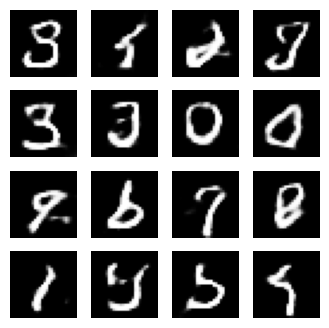

In [33]:
train(train_dataset, EPOCHS)

마지막 체크포인트를 복구합니다.

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성


In [35]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

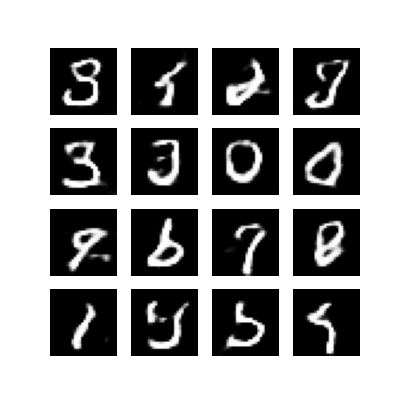

In [36]:
display_image(EPOCHS)

`imageio`로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

In [37]:
anim_file = 'dcgan.gif'  #애니메이션 이미지 파일의 경로를 저장

# imageio 라이브러리를 사용하여 애니메이션 파일을 쓰는 작업 시작
with imageio.get_writer(anim_file, mode='I') as writer:
    # 'image*.png' 패턴을 가진 모든 파일의 이름을 가져옵니다.
    filenames = glob.glob('image*.png')
    # 파일 이름을 정렬합니다. (예: image1.png, image2.png, ...)
    filenames = sorted(filenames)
    for filename in filenames:
        # 각각의 이미지 파일을 읽어옵니다.
        image = imageio.imread(filename)
        # 읽은 이미지를 애니메이션에 추가
        writer.append_data(image)
    # 마지막 이미지를 한 번 더 애니메이션에 추가. (원하는 특정 효과를 위해 같은 이미지를 2번 연속으로 넣음.)
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-37-122a07945868>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-37-122a07945868>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


tensorflow_docs.vis.embed 모듈의 embed_file 함수는 이미지 파일을 HTML에 임베드하는 함수입니다. 이 함수는 이미지 파일의 URL 또는 경로를 인자로 받아 HTML에 임베드할 태그를 반환합니다.  
Jupyter Notebook은 웹 기반의 대화식 컴퓨팅 환경이므로, 셀의 출력부에 나타나는 모든 것은 기본적으로 HTML로 렌더링될 수 있습니다.   
따라서, embed.embed_file(anim_file)를 Jupyter Notebook의 셀에서 실행하면, 해당 셀의 아래 출력 영역에 anim_file에 해당하는 애니메이션 또는 이미지가 나타나게 됩니다.


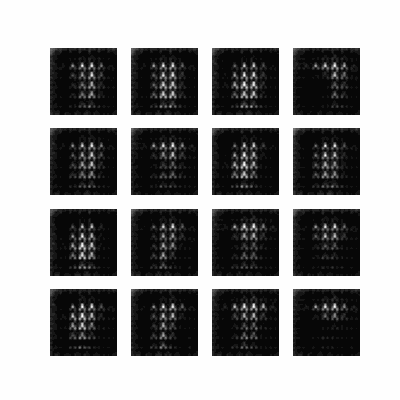

In [38]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)  # anim_file에 지정된 이미지 파일을 HTML에 임베드